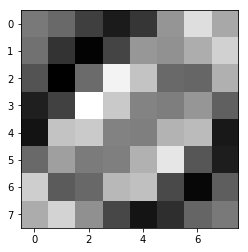

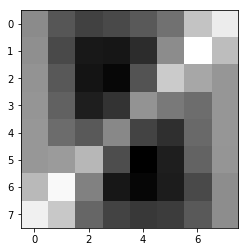

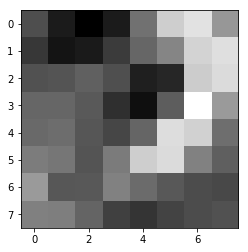

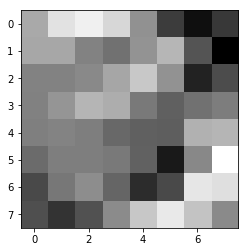

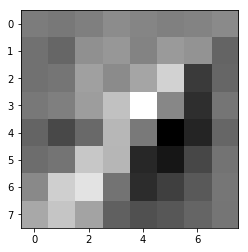

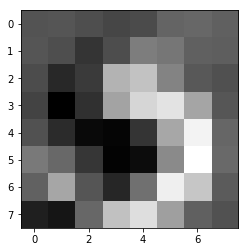

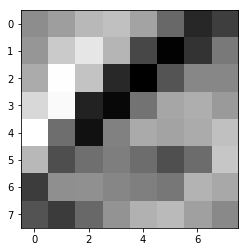

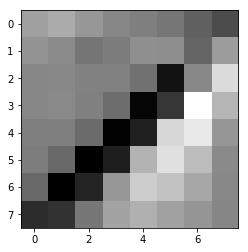

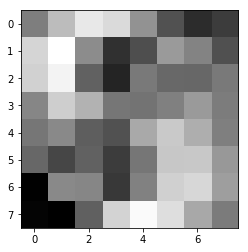

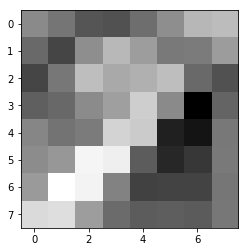

Question 1: The average conditional likelihood for training data is -0.124624436669
Question 1: The average conditional likelihood for testing data is -0.196673203255
Question 2: The most likely posterior class for training data is [[ 6.]
 [ 0.]
 [ 0.]
 ..., 
 [ 3.]
 [ 1.]
 [ 6.]]
Question 2: The most likely posterior class for testing data is [[ 1.]
 [ 6.]
 [ 7.]
 ..., 
 [ 3.]
 [ 8.]
 [ 4.]]
Question 3: The accuracy rate for training data is 0.9814285714285714
Question 3: The accuracy rate for testing data is 0.97275


In [467]:
'''
Question 1 Skeleton Code

Here you should implement and evaluate the Conditional Gaussian classifier.
'''

import data
import numpy as np
# Import pyplot - plt.imshow is useful!
import matplotlib.pyplot as plt

def compute_mean_mles(train_data, train_labels):
    '''
    Compute the mean estimate for each digit class

    Should return a numpy array of size (10,64)
    The ith row will correspond to the mean estimate for digit class i
    '''
    means = np.zeros((10, 64))
    # Compute means
    
    for i in range(0,10):
        train_class = get_digits_by_label(train_data,train_labels,i)
        means[i] = train_class.mean(axis=0)
    
    return means

def compute_sigma_mles(train_data, train_labels):
    '''
    Compute the covariance estimate for each digit class

    Should return a three dimensional numpy array of shape (10, 64, 64)
    consisting of a covariance matrix for each digit class 
    '''
    covariances = np.zeros((10, 64, 64))
    # Compute covariances
    
    # Get a 10X64 of the means for all digits
    means = compute_mean_mles(train_data,train_labels)
    
    # Compute covariance for all digits using formula E((X-mean)(X-mean)T) with added identity matrix 0.01I
    
    for i in range(0,10):
        train_class = data.get_digits_by_label(train_data,train_labels,i)
        cov = train_class - train_class.mean(axis=0)
        for j in range(0,64):
            for n in range(0,64):
                num = np.dot(cov[:,j],cov[:,n].T)
                den = len(train_class)
                covariances[i,j,n]=num/den 
                
        covariances[i,:,:] = covariances[i,:,:] + 0.01 * np.eye(64)
       
    return covariances

def generative_likelihood(digits, means, covariances):
    '''
    Compute the generative log-likelihood:
        log p(x|y,mu,Sigma)

    Should return an n x 10 numpy array 
    '''
    d = 64
    gene_p = np.zeros((len(digits),10))
    for i in range(0,len(digits)):  

        for j in range(0,10):

            term1 = (2*np.pi)**(-d/2)
            term2 = np.linalg.det(covariances[j])**(-1/2)
            term3 = np.exp(-1/2*np.mat((digits[i]-means[j]).reshape((64,1)).T)*np.mat(np.linalg.inv(covariances[j]))*np.mat((digits[i]-means[j]).reshape((64,1))))            
            gene_p[i,j] = term1 * term2 * term3
            
    log_gene_p = np.log(gene_p)
    
    return log_gene_p

def conditional_likelihood(digits, means, covariances):
    '''
    Compute the conditional likelihood:

        log p(y|x, mu, Sigma)

    This should be a numpy array of shape (n, 10)
    Where n is the number of datapoints and 10 corresponds to each digit class
    '''
    
    gen_likelihood = np.exp(generative_likelihood(digits,means,covariances))
    
    p_x = np.zeros((len(digits),1))

    for i in range(0,len(digits)):
        p_x[i] = np.sum(gen_likelihood[i,:]*0.1)
        
    con_likelihood = np.zeros((len(digits),10))
    for i in range(0,10):
        con_likelihood[:,i:i+1] = np.log(gen_likelihood[:,i]).reshape(len(digits),1) + np.log(0.1) - np.log(p_x).reshape(len(digits),1)
    
    return con_likelihood

def avg_conditional_likelihood(digits, labels, means, covariances):
    '''
    Compute the average conditional likelihood over the true class labels

        AVG( log p(y_i|x_i, mu, Sigma) )

    i.e. the average log likelihood that the model assigns to the correct class label
    '''
    cond_likelihood = conditional_likelihood(digits, means, covariances)

    # Compute as described above and return
    
    cond_likeli_sum = 0
    
    for i in range(0,len(labels)):
        cond_likeli_sum = cond_likeli_sum + cond_likelihood[i,int(labels[i])]
        
    avg_cond_likelihood = cond_likeli_sum/len(labels)

    return avg_cond_likelihood

def classify_data(digits, means, covariances):
    '''
    Classify new points by taking the most likely posterior class
    '''
    cond_likelihood = conditional_likelihood(digits, means, covariances)
    # Compute and return the most likely class
    
    prediction = np.zeros((len(digits),1))
    
    for i in range(0,len(digits)):
        prediction[i] = np.argmax(cond_likelihood[i])

    return prediction

def accuracy(digits, labels, pred):
    '''
    This calculate the accuracy rate
    '''
    accurate= 0 
    
    for i in range(0,len(digits)):
        if pred[i] == labels[i]:
            accurate = accurate + 1
    rate = accurate/len(digits)
    
    return rate


def eigenvectors(covariances):
    eig_vec = np.zeros((10,64,64))
    eig_val = np.zeros((10,64))
    digit = np.zeros((10,8,8))
    
    for i in range(0,10):
        eig_val[i,:],eig_vec[i,:,:] = np.linalg.eig(covariances[i,:,:])
        max_num = np.argmax(eig_val[i])
        digit[i,:,:] = eig_vec[i,:,max_num].reshape(8,8)
    return digit
    
    
    
def main():
    
    # Change for different file name and path
    zipfile ='hw5digits.zip'
    data_dir = r"C:\Users\natha\Box Sync\CSC2515 Introduction to Machine Learning and Data Mining\HomeWork 5"
    
    train_data, train_labels, test_data, test_labels = data.load_all_data_from_zip(zipfile,data_dir)

    # Fit the model
    means = compute_mean_mles(train_data, train_labels)
    covariances = compute_sigma_mles(train_data, train_labels)
    
    # Evaluation
    
    #Get average conditional likelihood for both training data and testing data
    train_likelihood = avg_conditional_likelihood(train_data, train_labels, means, covariances)
    test_likelihood = avg_conditional_likelihood(test_data, test_labels, means, covariances)
    
    #Get prediction from classify_data function with most likely posterior class
    y_train_pred = classify_data(train_data, means, covariances)
    y_test_pred = classify_data(test_data, means, covariances)
    
    #Get the accuracy rate with our model using the function accuracy
    train_accuracy = accuracy(train_data,train_labels,y_train_pred)
    test_accuracy = accuracy(test_data,test_labels,y_test_pred)
    
    
    #Print digit
    value = eigenvectors(covariances)
    for i in range(0,10):
        plt.figure(i+1)
        plt.imshow(value[i,:,:],cmap='gray')
        plt.show()
    
    
    #Print desired results 
    print("Question 1: The average conditional likelihood for training data is",train_likelihood)
    print("Question 1: The average conditional likelihood for testing data is",test_likelihood)
    
    print("Question 2: The most likely posterior class for training data is",y_train_pred)
    print("Question 2: The most likely posterior class for testing data is",y_test_pred)
    
    print("Question 3: The accuracy rate for training data is",train_accuracy)
    print("Question 3: The accuracy rate for testing data is",test_accuracy)



if __name__ == '__main__':
    main()
